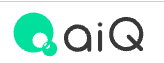

[disclaimer](../../disclaimer.txt/)

# aiQ Pos Consumer Goods/Elec/Retailer Evenly

本サンプルノートブックでは以下の3つのオルタナティブデータのファクターリターンをそれぞれ作成し、1/3ずつ資産配分をした合成ポートフォリオを考えます。
それぞれのファクターリターンの相関が低いことと、合成ポートフォリオの高いパフォーマンスが確認できます。


- aiQ POS Csmr Goods
- POS Elec Goods
- POS Retailer

In [1]:
# 自作モジュールを自動更新を行うためのコマンド
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.io
from pathlib import Path
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import aiq_pos_elec_goods as sc_elec
from libs.dataset import aiq_pos_retailer as sc_retailer
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- standard data handler のインスタンスを作成する
- data handler はデータ取得やデータ加工のライブラリを保持するオブジェクト

In [3]:
verbose = False
sdh = DAL()
sdh.transform.verbose = verbose

## Step2: Load Data to `sdh`
ここではデータ分析のデモが主眼であるため、個別に用意しておいた簡易ローダーを経由してデータを読み込むこととする

In [4]:
dat_id_retail = sc_retailer.register_retailer_data(sdh)
data_id_goods = sc_goods.register_csmr_goods_data(sdh)
data_id_elec = sc_elec.register_elec_goods_data(sdh)
data_id_mkt = sc_common.register_market(sdh, data_dir=DEFAULT_DIR, yf_switch=False, base_data_id=[dat_id_retail, data_id_goods, data_id_elec])

display(sdh.extract_definition)

category data_source   source    table           alias  \
data_id                                                          
1        RawData    external   sample  Unknown    pos_retailer   
2        RawData    external   sample  Unknown  pos_csmr_goods   
3        RawData    external   sample  Unknown  pos_elec_goods   
4        RawData    External  Unknown  Unknown          market   

                                                   tickers  \
data_id                                                      
1        [1925, 2212, 2267, 2651, 2653, 2659, 2660, 266...   
2        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
3        [1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...   
4        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2010-04-30 00:00:00  2024-07-31 00:00:00  
2        [TICKER, DATETIME]  2008-03-16 00:00:00  2024-07-28 00:00:00  
3        [TICKER, DATETIME]  2009-01-01 00:00:00  2024-07-31 00:00:00  
4        [TICKER, DATETIME]  2007-01-04 00:00:00  2024-07-11 00:00:00

### データが `sdh` に登録できたかを確認する

In [5]:
sdh.set_alias(
    {dat_id_retail: 'retail', data_id_goods: 'goods', 
     data_id_elec: 'elec', data_id_mkt: 'mkt'})

## Step3: 個々のデータセットのファクタリターンを確認する
組み合わせる前に、個々のファクターリターンのパフォーマンスを確認

In [6]:
# Step3 で使うオブジェクトをロードしておく
from aiq_strategy_robot.evaluator import AltDataEvaluator, inv_return_stats, cumplot_return

In [7]:
# データ評価に使うメインクラスのインスタンスを作成
ade = AltDataEvaluator(sdh)

In [8]:
# 市場データを生値から変化率に変換しておく
bcktest_return_id = sdh.transform.log_diff(1, data_id=data_id_mkt, fields='close').variable_ids[0]

### Step3.1: POS CSMR Goods
- weekly のリバランス
- データは最短でも週末から4営業日のラグ

In [9]:
n_shift = 6    # データ発行のタイミングラグを考慮
n_rolling = 12 # 3ヶ月の移動平均を計算
n_diff = 52    # 前年同週比を計算

In [10]:
signal_goods_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_goods)
    .resample('W', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=7)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [11]:
nq = 3
exe_cost = 0.0005

dfqret_goods, stats, dfsigqt = ade.q_backtest(
    signal_goods_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.393311  0.026049  0.133373  0.195312  0.542254      9.623244   
#2           0.915318  0.060623  0.134472  0.450820  0.541441     12.994096   
#3           1.269925  0.084109  0.135226  0.621985  0.556338      9.703491   
#3-#1        0.876614  0.058059  0.048968  1.185657  0.531961     19.326735   
#3-#1(cost)  0.730710  0.048396  0.048977  0.988137  0.526273     19.326735   

               Max_DD  Calmar Ratio  
#1          -0.526705      0.049457  
#2          -0.409792      0.147935  
#3          -0.411573      0.204359  
#3-#1       -0.065562      0.885556  
#3-#1(cost) -0.069987      0.691496

### Step3: POS Retailer
- monthly のリバランス
- データは最短でも月末から5営業日のラグ

In [12]:
n_shift = 7   # データ発行のタイミングラグを考慮
n_rolling = 2 # 2ヶ月の移動平均を計算（データが月次のため）
n_diff = 12   # 前年同月比を計算

In [13]:
signal_retailer_id = (
    sdh.transform
    .multiply('pos_sales', 'share', data_id=dat_id_retail)
    .resample('M', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=31)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [14]:
nq = 3
exe_cost = 0.0005

dfqret_retailer, stats, dfsigqt = ade.q_backtest(
    signal_retailer_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.601607  0.045929  0.137152  0.334878  0.529244     10.078817   
#2           1.159596  0.088528  0.141732  0.624616  0.540626     11.355023   
#3           1.786536  0.136391  0.143935  0.947585  0.548846      8.479764   
#3-#1        1.184929  0.090462  0.069344  1.304543  0.537464     18.558581   
#3-#1(cost)  1.063383  0.081183  0.069345  1.170708  0.532090     18.558581   

               Max_DD  Calmar Ratio  
#1          -0.604328      0.076000  
#2          -0.450649      0.196446  
#3          -0.410303      0.332416  
#3-#1       -0.126101      0.717375  
#3-#1(cost) -0.129279      0.627964

### Step3.3: POS Elec Goods
- daily のリバランス
- データは最短でも3営業日のラグ

In [15]:
n_shift = 8    # データ発行のタイミングラグを考慮
n_rolling = 14 # 14日の移動平均を計算（データは日次）
n_diff = 252   # 前年同日比を取るため
min_period = int(max(np.floor(n_rolling * 5 / 7), 1))

In [16]:
signal_elec_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_elec)
    .resample('D', 'last')
    .sma(n_rolling, min_period)
    .reindex(label=bcktest_return_id)
    .log_diff(n_diff)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [17]:
nq = 3
exe_cost = 0.0005

dfqret_elec, stats, dfsigqt = ade.q_backtest(
    signal_elec_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1          -0.048228 -0.003340  0.202485 -0.016493  0.529595     23.034939   
#2           0.888004  0.061491  0.203569  0.302067  0.534693     39.131215   
#3           1.480075  0.102490  0.202218  0.506831  0.548003     23.824997   
#3-#1        1.528303  0.105830  0.118261  0.894887  0.538091     46.859935   
#3-#1(cost)  1.189949  0.082400  0.118245  0.696859  0.531294     46.859935   

               Max_DD  Calmar Ratio  
#1          -0.781168     -0.004275  
#2          -0.574568      0.107022  
#3          -0.486168      0.210813  
#3-#1       -0.213449      0.495811  
#3-#1(cost) -0.255725      0.322221

## Step4: ファクターリターンの合成
- Step3.1 - 3.3 で求めたデータセットごとのファクターリターンをもとに等ウェイトのポートフォリオを作成する
- R/R の大幅な改善が確認できる (R/R が2.1に改善）
- ファクターリターン間の相関も極めて低いことが分かる

In [18]:
# 単純に Step3.1 - 3.3 のファクターリターンデータを取得する
elec_long_short = dfqret_elec['#3-#1'].rename('elec')
csmr_long_short = dfqret_goods['#3-#1'].rename('csmr')
retailer_long_short = dfqret_retailer['#3-#1'].rename('retailer')

# pos retailer ファクターのリバランスが一番長いため、他のファクターもそれに合わせる
elec_long_short = elec_long_short.resample('M').sum()
csmr_long_short = csmr_long_short.resample('M').sum()
retailer_long_short = retailer_long_short.resample('M').sum()

In [19]:
# 全てのファクターリターンが存在している時期にのみ合成ポートフォリオの期間を限定する
min_date = retailer_long_short.index.min()
max_date = elec_long_short.index.max()

In [20]:
# 単純に等ウェイトのポートフォリオを求める
portfolio = pd.concat([elec_long_short, csmr_long_short, retailer_long_short],axis=1)
portfolio = portfolio[portfolio.index>min_date]
portfolio = portfolio[portfolio.index<max_date]
portfolio['portfolio'] = portfolio.mean(axis=1)

In [21]:
# 等ウェイトポートフォリオのパフォーマンスを確認する
cumplot_return(portfolio, em_pattern='portfolio')
inv_return_stats(portfolio)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R    Max_DD  \
elec       1.608846  0.124466  0.105711  1.177412  0.628205 -0.124436   
csmr       0.830476  0.064248  0.044492  1.444027  0.641026 -0.046721   
retailer   1.180698  0.091343  0.078274  1.166964  0.619355 -0.103809   
portfolio  1.206674  0.093352  0.044317  2.106458  0.724359 -0.042489   

           Calmar Ratio  
elec           1.000236  
csmr           1.375155  
retailer       0.879910  
portfolio      2.197093

### ファクターリターン相関も確認

In [22]:
# ファクターリターン同士の相関も極めて低いことが確認できる
portfolio.corr()

elec      csmr  retailer  portfolio
elec       1.000000  0.005182 -0.105327   0.734835
csmr       0.005182  1.000000  0.012800   0.346308
retailer  -0.105327  0.012800  1.000000   0.509277
portfolio  0.734835  0.346308  0.509277   1.000000